In [1]:
import io
import aiohttp
import asyncio
import requests
from tqdm.auto import tqdm
from glob import glob

import meerkat as mk

from PIL import Image

In [2]:
# Load NGOA published images at 224 x 224 (rescaled to fit this size) and CLIP embeddings
dp = mk.DataPanel({'image_path': glob('/data/datasets/opendata/published_images_224/*')})
dp['uuid'] = dp['image_path'].str.split("/").str.get(-1).str.rstrip(".jpg")
dp['image_224'] = mk.ImageColumn.from_filepaths(dp['image_path'])
dp = dp.merge(mk.DataPanel.read('/data/datasets/opendata/ngoa_published_images_224_clip.mk/'), on='uuid')
dp = dp.sort('uuid')

In [3]:
ngoa = mk.get(
    'ngoa',
    '/data/datasets/opendata/',
)
ngoa

/home/karan/meerkat/meerkat/datapanel.py:436: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return cls.from_pandas(pd.read_csv(filepath, *args, **kwargs))


{'objects': DataPanel(nrows: 137923, ncols: 29),
 'published_images': DataPanel(nrows: 104505, ncols: 13),
 'objects_constituents': DataPanel(nrows: 798353, ncols: 12),
 'constituents': DataPanel(nrows: 26102, ncols: 13),
 'constituents_text_entries': DataPanel(nrows: 6894, ncols: 4),
 'locations': DataPanel(nrows: 1083, ncols: 6)}

In [4]:
published_images = ngoa['published_images']
objects = ngoa['objects']
objects_constituents = ngoa['objects_constituents']
constituents = ngoa['constituents']
constituents_text_entries = ngoa['constituents_text_entries']
locations = ngoa['locations']

In [5]:
objects_constituents

,objectid (PandasSeriesColumn),constituentid (PandasSeriesColumn),displayorder (PandasSeriesColumn),roletype (PandasSeriesColumn),role (PandasSeriesColumn),prefix (PandasSeriesColumn),suffix (PandasSeriesColumn),displaydate (PandasSeriesColumn),beginyear (PandasSeriesColumn),endyear (PandasSeriesColumn),country (PandasSeriesColumn),zipcode (PandasSeriesColumn)
0,8,12,7,owner,current owner,NaN,NaN,1937 -,1937.0,NaN,United States,20565
1,8,427,1,donor,donor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,427,2,donor,source,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8,427,6,owner,previous owner,NaN,NaN,1936 - 1937,1936.0,1937.0,NaN,NaN
4,8,1102,5,owner,previous owner,NaN,", New York, NY",1936 - 1936,1936.0,1936.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
798348,213992,12,2,owner,current owner,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798349,213992,13318,1,artist,artist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798350,213992,37625,1,donor,source,NaN,NaN,NaN,NaN,NaN,NaN,NaN
798351,213992,37625,1,owner,previous owner,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Merge the images and embeddings into the published_images table
published_images = mk.merge(published_images, dp, on="uuid")

In [10]:
# Merge the published_images and objects tables, along with embeddings saved on disk for the text columns in the objects
dp = mk.merge(published_images, objects, left_on='depictstmsobjectid', right_on='objectid')
dp = dp['objectid', 'uuid', 'image_224', 'clip(image_224)', 'parentid', 'beginyear', 'endyear', 'medium', 'dimensions', 'inscription', 'attribution', 'creditline', 'visualbrowserclassification']
dp = dp.merge(
    mk.DataPanel.read(
        '/data/datasets/opendata/ngoa_objects_images_clip.mk/', 
    )['objectid', 'clip(medium)', 'clip(dimensions)', 'clip(inscription)', 'clip(attribution)', 'clip(creditline)'],
    on='objectid'
)

,objectid (PandasSeriesColumn),uuid (PandasSeriesColumn),image_224 (ImageColumn),clip(image_224) (NumpyArrayColumn),parentid (PandasSeriesColumn),beginyear (PandasSeriesColumn),endyear (PandasSeriesColumn),medium (PandasSeriesColumn),dimensions (PandasSeriesColumn),inscription (PandasSeriesColumn),attribution (PandasSeriesColumn),creditline (PandasSeriesColumn),visualbrowserclassification (PandasSeriesColumn),clip(medium) (NumpyArrayColumn),clip(dimensions) (NumpyArrayColumn),clip(inscription) (NumpyArrayColumn),clip(attribution) (NumpyArrayColumn),clip(creditline) (NumpyArrayColumn)
0,11975,00004dec-8300-4487-8d89-562d0126b6a1,,"np.ndarray(shape=(512,))",11969.0,1937.0,1937.0,woodcut in red,NaN,NaN,Aristide Maillol,Rosenwald Collection,print,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
1,17387,00007f61-4922-417b-8f27-893ea328206c,,"np.ndarray(shape=(512,))",NaN,1936.0,1936.0,"watercolor, colored pencil, graphite, and heightening on paperboard","overall: 29.8 x 22.8 cm (11 3/4 x 9 in.)\r\nOriginal IAD Object: 8"" High 5"" Wide(top) 5 7/8"" Base",lower right in graphite: YoLande Delasser,Yolande Delasser,Index of American Design,drawing,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
2,19245,0000bd8c-39de-4453-b55d-5e28a9beed38,,"np.ndarray(shape=(512,))",NaN,1939.0,1939.0,"watercolor, graphite, and colored pencil on paperboard","overall: 40.5 x 30.4 cm (15 15/16 x 11 15/16 in.)\r\nOriginal IAD Object: 13"" High",lower right in graphite: E. Wein,Elsie Wein,Index of American Design,drawing,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"

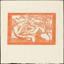
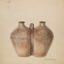
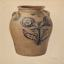

In [12]:
dp.head(3)

  0%|          | 0/817 [00:00<?, ?it/s]

,objectid (PandasSeriesColumn),uuid (PandasSeriesColumn),image_224 (ImageColumn),clip(image_224) (NumpyArrayColumn),parentid (PandasSeriesColumn),beginyear (PandasSeriesColumn),dimensions (PandasSeriesColumn),inscription (PandasSeriesColumn),attribution (PandasSeriesColumn),creditline (PandasSeriesColumn),visualbrowserclassification (PandasSeriesColumn),medium (PandasSeriesColumn),clip(medium) (NumpyArrayColumn)
0,11975,00004dec-8300-4487-8d89-562d0126b6a1,,"np.ndarray(shape=(512,))",11969.0,1937.0,NaN,NaN,Aristide Maillol,Rosenwald Collection,print,woodcut in red,"np.ndarray(shape=(512,))"
1,17387,00007f61-4922-417b-8f27-893ea328206c,,"np.ndarray(shape=(512,))",NaN,1936.0,"overall: 29.8 x 22.8 cm (11 3/4 x 9 in.)\r\nOriginal IAD Object: 8"" High 5"" Wide(top) 5 7/8"" Base",lower right in graphite: YoLande Delasser,Yolande Delasser,Index of American Design,drawing,"watercolor, colored pencil, graphite, and heightening on paperboard","np.ndarray(shape=(512,))"
2,19245,0000bd8c-39de-4453-b55d-5e28a9beed38,,"np.ndarray(shape=(512,))",NaN,1939.0,"overall: 40.5 x 30.4 cm (15 15/16 x 11 15/16 in.)\r\nOriginal IAD Object: 13"" High",lower right in graphite: E. Wein,Elsie Wein,Index of American Design,drawing,"watercolor, graphite, and colored pencil on paperboard","np.ndarray(shape=(512,))"
3,153987,0000e5a4-7d32-4c2a-97c6-a6b571c9fd71,,"np.ndarray(shape=(512,))",NaN,1612.0,sheet: 57.1 × 43 cm (22 1/2 × 16 15/16 in.) (trimmed to plate mark),"in image, at bottom: Hendrick Goltius.","Jan Muller, Hendrick Goltzius",Gift of Ruth Cole Kainen,print,engraving on laid paper,"np.ndarray(shape=(512,))"
4,23830,0001668a-dd1c-48e8-9267-b6d1697d43c8,,"np.ndarray(shape=(512,))",NaN,1936.0,overall: 50.5 x 39.3 cm (19 7/8 x 15 1/2 in.),NaN,Al Curry,Index of American Design,drawing,watercolor and graphite on paper,"np.ndarray(shape=(512,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104490,152409,fffd395e-a255-41fd-bf12-03c5eb948099,,"np.ndarray(shape=(512,))",150380.0,1838.0,plate: 10.9 x 16 cm (4 5/16 x 6 5/16 in.)\r\nsheet: 26.8 x 35.8 cm (10 9/16 x 14 1/8 in.),"by later hand, lower right verso in graphite: 1845 Calabi III, 30",Alexandre Calame,Ailsa Mellon Bruce Fund,print,etching,"np.ndarray(shape=(512,))"
104491,169631,fffe6d61-e686-478d-bafb-ddae9a48c4de,,"np.ndarray(shape=(512,))",NaN,1859.0,plate: 7.62 × 20.32 cm (3 × 8 in.)\r\nsheet: 13.97 × 26.19 cm (5 1/2 × 10 5/16 in.),lower right in plate: Whistler 1859,James McNeill Whistler,Corcoran Collection (Gift of Mrs. Josephine Boardman Crane),print,etching and drypoint in black on laid paper,"np.ndarray(shape=(512,))"
104492,166633,fffeab03-0f91-49ba-884a-648e6f84598f,,"np.ndarray(shape=(512,))",NaN,1887.0,image: 23.2 × 31.1 cm (9 1/8 × 12 1/4 in.)\r\nsheet: 47.9 × 60.4 cm (18 7/8 × 23 3/4 in.),"printed, lower center underneath image in black ink: ANIMAL LOCOMOTION. PLATE. 133 / Copyright, 1887, by EADWEARD MUYBRIDGE. All rights reserved.; on verso, by Corcoran Gallery of Art, lower left in red pencil: 87.7.133",Eadweard Muybridge,"Corcoran Collection (Museum Purchase, 1887)",photograph,collotype,"np.ndarray(shape=(512,))"
104493,39382,ffff2faf-fb5a-479c-b5dc-408245cdc1a0,,"np.ndarray(shape=(512,))",NaN,1547.0,NaN,NaN,Augustin Hirschvogel,Rosenwald Collection,print,etching,"np.ndarray(shape=(512,))"

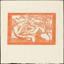
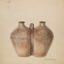
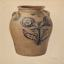
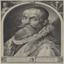
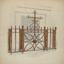
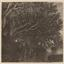
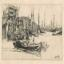
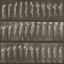
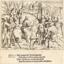
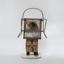

In [82]:
# Code for embedding the text columns in the objects table
dp['medium'] = dp['medium'].astype('str')
mk.embed(dp, 'medium')
dp['dimensions'] = dp['dimensions'].astype('str')
mk.embed(dp, 'dimensions')
dp['inscription'] = dp['inscription'].astype('str')
mk.embed(dp, 'inscription')
dp['attribution'] = dp['attribution'].astype('str')
mk.embed(dp, 'attribution')
dp['creditline'] = dp['creditline'].astype('str')
mk.embed(dp, 'creditline')

In [89]:
# Writing the embeddings to disk
# dp['objectid', 
#    'medium', 'dimensions', 'inscription', 'attribution', 'creditline', 
#    'clip(medium)', 'clip(dimensions)', 'clip(inscription)', 'clip(attribution)', 'clip(creditline)'].write('/data/datasets/opendata/ngoa_objects_images_clip.mk/')

In [ ]:
mk.DataPanel.read('/data/datasets/opendata/ngoa_objects_images_clip.mk/')

,objectid (PandasSeriesColumn),medium (PandasSeriesColumn),dimensions (PandasSeriesColumn),inscription (PandasSeriesColumn),attribution (PandasSeriesColumn),creditline (PandasSeriesColumn),clip(medium) (NumpyArrayColumn),clip(dimensions) (NumpyArrayColumn),clip(inscription) (NumpyArrayColumn),clip(attribution) (NumpyArrayColumn),clip(creditline) (NumpyArrayColumn)
0,11975,woodcut in red,nan,nan,Aristide Maillol,Rosenwald Collection,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
1,17387,"watercolor, colored pencil, graphite, and heightening on paperboard","overall: 29.8 x 22.8 cm (11 3/4 x 9 in.)\r\nOriginal IAD Object: 8"" High 5"" Wide(top) 5 7/8"" Base",lower right in graphite: YoLande Delasser,Yolande Delasser,Index of American Design,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
2,19245,"watercolor, graphite, and colored pencil on paperboard","overall: 40.5 x 30.4 cm (15 15/16 x 11 15/16 in.)\r\nOriginal IAD Object: 13"" High",lower right in graphite: E. Wein,Elsie Wein,Index of American Design,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
3,153987,engraving on laid paper,sheet: 57.1 × 43 cm (22 1/2 × 16 15/16 in.) (trimmed to plate mark),"in image, at bottom: Hendrick Goltius.","Jan Muller, Hendrick Goltzius",Gift of Ruth Cole Kainen,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
4,23830,watercolor and graphite on paper,overall: 50.5 x 39.3 cm (19 7/8 x 15 1/2 in.),nan,Al Curry,Index of American Design,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
...,...,...,...,...,...,...,...,...,...,...,...
104490,152409,etching,plate: 10.9 x 16 cm (4 5/16 x 6 5/16 in.)\r\nsheet: 26.8 x 35.8 cm (10 9/16 x 14 1/8 in.),"by later hand, lower right verso in graphite: 1845 Calabi III, 30",Alexandre Calame,Ailsa Mellon Bruce Fund,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
104491,169631,etching and drypoint in black on laid paper,plate: 7.62 × 20.32 cm (3 × 8 in.)\r\nsheet: 13.97 × 26.19 cm (5 1/2 × 10 5/16 in.),lower right in plate: Whistler 1859,James McNeill Whistler,Corcoran Collection (Gift of Mrs. Josephine Boardman Crane),"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
104492,166633,collotype,image: 23.2 × 31.1 cm (9 1/8 × 12 1/4 in.)\r\nsheet: 47.9 × 60.4 cm (18 7/8 × 23 3/4 in.),"printed, lower center underneath image in black ink: ANIMAL LOCOMOTION. PLATE. 133 / Copyright, 1887, by EADWEARD MUYBRIDGE. All rights reserved.; on verso, by Corcoran Gallery of Art, lower left in red pencil: 87.7.133",Eadweard Muybridge,"Corcoran Collection (Museum Purchase, 1887)","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"
104493,39382,etching,nan,nan,Augustin Hirschvogel,Rosenwald Collection,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))","np.ndarray(shape=(512,))"


In [100]:
dp.groupby('creditline')['uuid'].count().sort(by='uuid', ascending=False).head(20)

,uuid (NumpyArrayColumn),creditline (PandasSeriesColumn)
0,18200,Index of American Design
1,17402,Rosenwald Collection
2,5295,Samuel H. Kress Collection
3,4465,Ailsa Mellon Bruce Fund
4,4328,"Reba and Dave Williams Collection, Gift of Reba and Dave Williams"
...,...,...
15,1163,Corcoran Collection (Gift of Dr. Armand Hammer)
16,1045,"Gift of The Mark Rothko Foundation, Inc."
17,1024,Gift of Charles Isaacs and Gregory Leroy
18,1019,Gift of Dorothy J. and Benjamin B. Smith


In [101]:
dp.groupby(by='beginyear')['uuid'].count().sort(by='uuid', ascending=False).head(20)

,uuid (NumpyArrayColumn),beginyear (NumpyArrayColumn)
0,5054,1936.0
1,4496,1935.0
2,4010,1937.0
3,3467,1796.0
4,2837,1938.0
...,...,...
15,922,1884.0
16,853,1967.0
17,828,1903.0
18,817,1977.0


In [102]:
dp.groupby('attribution')['uuid'].count().sort(by='uuid', ascending=False).head(50)

,uuid (NumpyArrayColumn),attribution (PandasSeriesColumn)
0,3364,"Various Artists, including William Blake, after John Gabriel Stedman"
1,2342,Honoré Daumier
2,1698,Carrie Mae Weems
3,1672,Jasper Johns
4,1613,Alfred Stieglitz
...,...,...
45,269,Pierre Bonnard
46,269,Sir Muirhead Bone
47,262,Marc Chagall
48,257,Susan Meiselas


In [103]:
dp.groupby('visualbrowserclassification')['uuid'].count().sort(by='uuid', ascending=False).head(50)

,uuid (NumpyArrayColumn),visualbrowserclassification (PandasSeriesColumn)
0,46249,print
1,32304,drawing
2,15440,photograph
3,13798,sculpture
4,7962,volume
5,3830,painting
6,1632,decorative art
7,1554,portfolio
8,69,technical material
9,5,new media
